# Statistics for Datra

In [104]:
from src import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zeus
import scipy.stats as stats
import scipy

In [105]:
# read data from lighthouse_flash_data.txt
with open('lighthouse_flash_data.txt', 'r') as file:
    lines = file.readlines()

data = np.array([list(map(float, line.strip().split())) for line in lines]).flatten()



In [106]:
data

array([ 5.45077359e+00,  1.01393008e-01,  2.88307026e+00,  2.08561540e-01,
        3.88735155e-01,  1.49236669e+00, -1.10860014e+00,  3.91606199e+00,
        1.10935762e+00,  1.47715478e+00, -2.62856487e+00,  2.08803771e-01,
       -1.78031276e+00,  5.58381835e-01,  7.05289847e+01,  1.40378082e-03,
       -1.82069712e-01,  2.81527513e+00, -8.65821789e-01,  9.57735954e-01,
        2.37516040e+00,  4.10477536e-01,  4.86516180e-01,  2.13381927e+00,
       -2.21155541e+00,  4.76037644e-01,  9.72888804e-01,  1.05901645e+00,
       -4.71733272e+00,  2.18390632e-01, -1.27137259e+00,  2.33958073e-01,
       -1.88736974e+01,  9.33935958e-03, -1.29333594e+00,  4.16835632e-01,
       -6.61040916e-01,  7.61245600e+00,  1.35643268e+01,  5.16884623e-03])

In [107]:
data_x, data_I = data[0::2], data[1::2]

In [108]:
data_x

array([  5.45077359,   2.88307026,   0.38873515,  -1.10860014,
         1.10935762,  -2.62856487,  -1.78031276,  70.52898471,
        -0.18206971,  -0.86582179,   2.3751604 ,   0.48651618,
        -2.21155541,   0.9728888 ,  -4.71733272,  -1.27137259,
       -18.87369737,  -1.29333594,  -0.66104092,  13.56432676])

In [109]:
# define log likelihood
log_likelihood = lambda alpha, beta: np.sum(np.log(Cauchy(data_x, alpha, beta)))


def neg_log_likelihood(x):
    alpha, beta = x    
    return -log_likelihood(alpha, beta)


In [110]:
# find the maximum likelihood estimate
result = scipy.optimize.minimize(neg_log_likelihood, np.array([0,1]), method='Nelder-Mead')
alpha_mlp, beta_mlp = result.x
print (alpha_mlp, beta_mlp)

-0.5221662541693433 1.6002197661563646


In [111]:
# # define log prior as uniform
# alpha_min, beta_min = -5, 0
# alpha_max, beta_max = 5, 10
# params = dict({'alpha_min': alpha_min, 'alpha_max': alpha_max, 'beta_min': beta_min, 'beta_max': beta_max})
# prior = lambda alpha, beta: 1 if alpha_min < alpha < alpha_max and beta_min < beta < beta_max else 0

In [112]:
# # define log prior as gaussian
# alpha_mu, alpha_std = 0, 1
# beta_mu, beta_std = 1, 1
# prior = lambda alpha, beta: stats.norm.pdf(alpha, alpha_mu, alpha_std) * stats.norm.pdf(beta, beta_mu, beta_std)

In [113]:
#define prior_alpha is gaussian with mean 0 and std 1
alpha_mu, alpha_std = 0, 1
prior_alpha = lambda alpha: stats.norm.pdf(alpha, alpha_mu, alpha_std)
#defin prior_beta as uniform distribution with min 0 max 100
beta_min, beta_max = 0, 100
prior_bete = lambda beta: stats.uniform.pdf(beta, beta_min, beta_max)

In [114]:
prior = lambda alpha, beta: prior_alpha(alpha) * prior_bete(beta)

In [115]:
# log(posterior) = log(prior) + log(likelihood)
def posterior(x): 
    alpha = x[0]
    beta = x[1]
    return np.exp(log_likelihood(alpha, beta)) * prior(alpha, beta)

def log_posterior(x):
    alpha = x[0]
    beta = x[1]
    return log_likelihood(alpha, beta) + np.log(prior(alpha, beta))

In [116]:
# sample from the log_posterior
N = 100000

initial_point = np.array([alpha_mlp, beta_mlp])
cov_matrix = np.array([[1, 0], [0, 1]])

sampler = MetropolisHastings(target_func = posterior, N = N, ndim = 2, initial_point = initial_point, cov_matrix = cov_matrix, thinning_factor = 1)
sampler.sample()
chain = sampler.get_chain()
sampler.summary()
sampler.reset()

Summary for Metropolis Hastings (Zachary)
---------
Number of Generations:  100000
Dimension:  2
Acceptance Rate:  0.31482
Integrated Autocorrelation Time:  [9.70726236]
Effective Sample Size:  [10301.56559582]


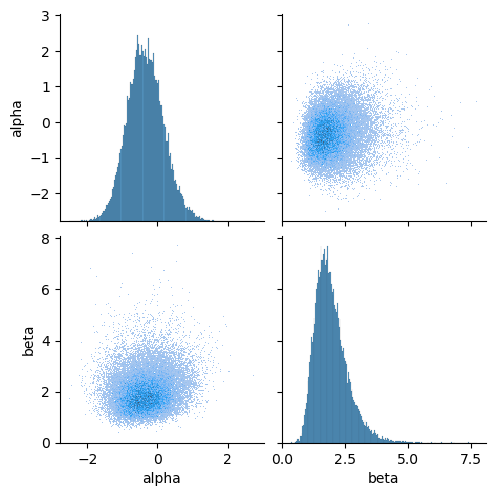

In [117]:
# save the chain to a pd dataframe
df = pd.DataFrame(chain, columns=['alpha', 'beta'])

# plot the chain
sns.pairplot(df, markers='o',kind ='hist')
plt.show()

In [118]:
# find the mean and std of each parameter
alpha_mean, beta_mean = df.mean()
alpha_std, beta_std = df.std()
print (f'alpha_mean: {alpha_mean}, beta_mean: {beta_mean}, alpha_std: {alpha_std}, beta_std: {beta_std}')

alpha_mean: -0.33943164927069336, beta_mean: 1.957531931221546, alpha_std: 0.5206651461534555, beta_std: 0.6508845363755215


In [ ]:
# cache the result of 

### Take Intensity into consideration 

In [119]:
new_log_likelihood = lambda alpha, beta,: np.sum(np.log(Cauchy(data_x, alpha, beta)))

In [120]:
log_likelihood_l = lambda alpha, beta, I0: np.sum(np.log(log_normal(data_I, alpha, beta, I0, 1)))

In [121]:
new_log_likelihood = lambda alpha, beta, I0: log_likelihood(alpha, beta) + log_likelihood_l(alpha, beta, I0)

def neg_log_likelihood_l(x):
    alpha, beta, I0 = x    
    return -new_log_likelihood(alpha, beta, I0)


In [122]:
# find l that maximizes the likelihood
result = scipy.optimize.minimize(neg_log_likelihood_l, np.array([alpha_mlp,beta_mlp,1]), method='Nelder-Mead')
alpha_mlp, beta_mlp, I0_mlp = result.x
print (f'alpha_mlp: {alpha_mlp}, beta_mlp: {beta_mlp}, I0_mlp: {I0_mlp}')

alpha_mlp: 3.110879231302704, beta_mlp: 2.4973124317784015, I0_mlp: 4.096507670656351


In [123]:
I_0_mu, I_0_std = 1, 1
prior_l = lambda I0: stats.norm.pdf(I0, I_0_mu, I_0_std)

In [124]:
def new_posterior(x): 
    alpha = x[0]
    beta = x[1]
    I0 = x[2]
    return np.exp(new_log_likelihood(alpha, beta, I0)) * prior(alpha, beta) * prior_l(I0)

def new_log_posterior(x):
    alpha = x[0]
    beta = x[1]
    I0 = x[2]
    return np.log(new_log_likelihood(alpha, beta, I0))

In [125]:
# sample from the posterior using Metropolis-Hastings

N = 100000

initial_point = np.array([0, 0, 1])

cov_matrix = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

sampler = MetropolisHastings(target_func = new_posterior, N = N, ndim = 3, initial_point = initial_point, cov_matrix = cov_matrix, thinning_factor = 1)
sampler.sample()
chain = sampler.get_chain()
sampler.summary()
sampler.reset()

/var/folders/ry/r28_vw1507xg9nf1c8mtsr500000gn/T/ipykernel_838/3386881046.py:2: RuntimeWarning: divide by zero encountered in log
  log_likelihood = lambda alpha, beta: np.sum(np.log(Cauchy(data_x, alpha, beta)))
/Users/zhongjunbao/Documents/Cambridge_Mphil/02Statistics_for_Data_Science/Coursework_Project_xz447/src.py:129: RuntimeWarning: divide by zero encountered in scalar divide
  a = self.target_func(y) / self.target_func(x) * self.inv_gaussian(x, y, self.cov_matrix) / self.inv_gaussian(y, x, self.cov_matrix)


Summary for Metropolis Hastings (Zachary)
---------
Number of Generations:  100000
Dimension:  3
Acceptance Rate:  0.13963
Integrated Autocorrelation Time:  [24.9656642]
Effective Sample Size:  [4005.50128356]


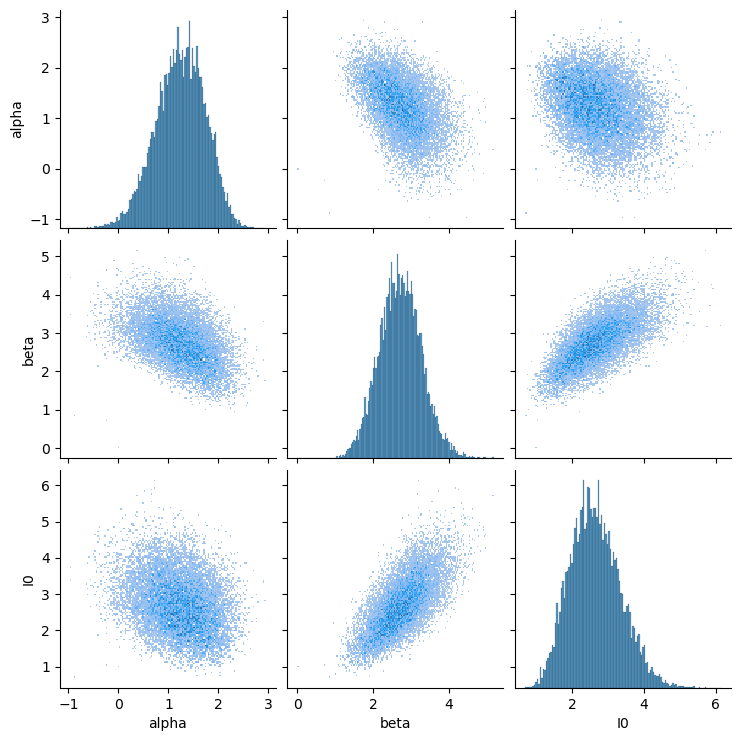

In [126]:
# save the chain to a pd dataframe
df_I = pd.DataFrame(chain, columns=['alpha', 'beta', 'I0'])

# plot the chain
sns.pairplot(df_I, markers='o',kind ='hist')
plt.show()

In [127]:
# find the mean and std of each parameter
alpha_mean, beta_mean, I0_mean = df.mean()
alpha_std, beta_std, I0_std = df.std()
print (f'alpha_mean: {alpha_mean}, beta_mean: {beta_mean}, I0_mean: {I0_mean}, alpha_std: {alpha_std}, beta_std: {beta_std}, I0_std: {I0_std}')

alpha_mean: 1.2413290576303841, beta_mean: 2.7168456706342945, I0_mean: 2.6526508916913234, alpha_std: 0.4900134641464037, beta_std: 0.5535257330377337, I0_std: 0.7014610706414764


In [ ]:
# plot the distribution of alpha before and after the lighthouse flash
plt.figure()
sns.kdeplot(df['alpha'], label='before flash')
sns.kdeplot(df_I['alpha'], label='after flash')
plt.xlabel('alpha')
plt.ylabel('density')
plt.title('alpha distribution')
plt.legend()
plt.show()